# Rede Neural Convolucional com Keras

Neste exercício, vamos construir uma rede neural convolucional (CNN) para classificar os digitos do MNIST. 

![http://cs231n.github.io/convolutional-networks/](https://hackernoon.com/hn-images/0*9J3MK1gd2zrFDzDN.gif)

Source: http://cs231n.github.io/convolutional-networks/

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

## Camada Convolucional

# Carregar dados para treinamento

## Pré-processamento dos dados para treinamento:

Diferentemente do que fizemos na nossa rede neural, a entrada da CNN é uma imagem, então não é necessário transformar a imagem em um vetor. No entanto, precisamos informar nossa rede quanto às dimensões das nossas imagens. Imagens coloridas normalmente têm 3 canais (RGB), mas estamos trabalhando com imagens em escala de cinza, que contém apenas um canal. **Importante**, O Tensorflow assume que o número de canais sempre está na última dimensão da imagem, enquanto o Pyorch assume a primeira dimensão:

```
Tensorflow -> (img_rows, img_cols, channels)
Pytorch -> (channels, img_rows, img_cols)
```

Além disso, nós escalamos as entradas para estarem no intervalo [0-1] ao invés de [0-255]. **Outros tipos de pré-processamento, como dimensionamento, normalização e cortes podem ser feitos nessa parte.**



In [2]:
mnist = tf.keras.datasets.mnist

# Carrega os dados, que já vem divididos em conjunto de treinamento e teste.
(x_trainVal, y_trainVal), (x_test, y_test) = mnist.load_data()

# Embaralha os dados e divide em 80% para treino, 20% para validação
nData = x_trainVal.shape[0]  
nTrain = int(nData * 0.8)  
randomIdx = np.random.permutation(np.arange(nData))
trainIdx = randomIdx[:nTrain] 
valIdx = randomIdx[nTrain:]

# Divide os dados
x_val, y_val = x_trainVal[valIdx], y_trainVal[valIdx]
x_train, y_train = x_trainVal[trainIdx], y_trainVal[trainIdx]

# Normaliza dados entre [0, 1]
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

print("Formato das imagens de treinamento", x_train.shape)
print("Formato dos rótulos de treinamento", y_train.shape)
print()

print("Formato das imagens de validação", x_val.shape)
print("Formato dos rótulos de validação", y_val.shape)


# Adiciona um canal no treino (H, W, C)
x_train = x_train[..., tf.newaxis]
x_val = x_val[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# One hot encoding dos labels
num_classes = len(np.unique(y_train))
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_oh = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes)
print(x_train.shape, y_train_oh.shape)

Formato das imagens de treinamento (48000, 28, 28)
Formato dos rótulos de treinamento (48000,)

Formato das imagens de validação (12000, 28, 28)
Formato dos rótulos de validação (12000,)
(48000, 28, 28, 1) (48000, 10)


## Nosso treino é balanceado?

Para cada classe, vamos checar quantos exemplos temos e calcular um peso. Isso pode ser útil para dizer ao modelo "prestar mais atenção" em amostras de uma classe com menos indivíduos durante o treinamento.

In [3]:
# Para o conjunto de treino
unique, counts = np.unique(y_train, return_counts=True)
print("Treino ---> ", dict(zip(unique, counts)), "\n")

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
train_class_weights = dict(enumerate(class_weights))
print(train_class_weights, "\n")

#Para o conjunto de teste ---> Nós usamos isso para calcular a acurácia normalizada
unique, counts = np.unique(y_test, return_counts=True)
print("Teste  ---> ", dict(zip(unique, counts)), "\n")

Treino --->  {0: 4731, 1: 5354, 2: 4837, 3: 4873, 4: 4653, 5: 4334, 6: 4759, 7: 5039, 8: 4719, 9: 4701} 

{0: 1.014584654407102, 1: 0.8965259618976467, 2: 0.9923506305561298, 3: 0.9850194951775088, 4: 1.0315925209542232, 5: 1.1075219197046609, 6: 1.0086152553057366, 7: 0.952569954356023, 8: 1.0171646535282899, 9: 1.021059349074665} 

Teste  --->  {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009} 



In [4]:
from tensorflow.keras import layers

model = tf.keras.Sequential()
#Camada convolucional com 10 filtros de tamanho 3x3 e ativação ReLU
model.add(layers.Conv2D(10, 3, padding='valid', activation='relu', input_shape=(28, 28, 1)))
#Max pooling de tamanho 2x2
model.add(layers.MaxPooling2D(pool_size=(2,2)))
#Operação de vetorização dos dados
model.add(layers.Flatten())
#Dropout com probabilidade de 0.2
model.add(layers.Dropout(0.2))
#Densa com 10 nós de saída
model.add(layers.Dense(10))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 10)        100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1690)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1690)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                16910     
Total params: 17,010
Trainable params: 17,010
Non-trainable params: 0
_________________________________________________________________


## Compile o modelo

Vamos definir a função de perda e o otimizador que usaremos para treinar nossa CNN, assim como especifiar que queremos salvar a acurácia em cada época. Usaremos a função de "categorical cross-entropy" como função de perda, e o otimizador SGD (Stochastic Gradient Descent). **Lembre-se que o Keras não retorna a acurácia normalizada!!**

In [5]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


## Treine o modelo!

Nós já estamos prontos para treinar nossa CNN! A função `model.fit` recebe os argumentos:
- **x_train & y_train_oh:** os dados de treino e suas classes.
- **epochs:** uma época ocorre a cada vez que **todos** seus dados de treino passam pela rede uma vez. Como CNNs são mais caras em termos computacionais que redes neurais simples, nós vamos processar apenas 1 época.
- **batch_size:** ao invés de otimizar sua rede em todos os dads de treino de uma só vez, nós normalmente otimizamos utilizando batches (pequeno conjunto pertencente aos dados de treino). Neste caso, nós iremos atualizar nossos pesos (backpropagation) depois do passo de "forward" (processamento do batch de 128 imagens);
- **class_weight:** os pesos de cada classe, considerando que elas não são balanceadas. Este parâmetro é responsável por ponderar a loss de acordo com a frequência de ocorrência de cada classe.
- **validation_data:** depois de cada época nosso modelo vai predizer esses dados, e retornar o resultado da função de perda, e a acurácia em relação a eles.

In [6]:
model.fit(x_train, y_train_oh, epochs=50, batch_size=32, class_weight=train_class_weights,
          validation_data=(x_val, y_val_oh))

Epoch 1/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1910 - accuracy: 0.9428 - val_loss: 0.1046 - val_accuracy: 0.9703
Epoch 2/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1011 - accuracy: 0.9692 - val_loss: 0.0786 - val_accuracy: 0.9754
Epoch 3/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0866 - accuracy: 0.9731 - val_loss: 0.0778 - val_accuracy: 0.9781
Epoch 4/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0816 - accuracy: 0.9750 - val_loss: 0.0771 - val_accuracy: 0.9784
Epoch 5/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0751 - accuracy: 0.9766 - val_loss: 0.0966 - val_accuracy: 0.9743
Epoch 6/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0716 - accuracy: 0.9780 - val_loss: 0.0901 - val_accuracy: 0.9786
Epoch 7/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0690 - accuracy: 0.9790 - val_loss: 0.0889 - val_accuracy:

Matriz de confusão


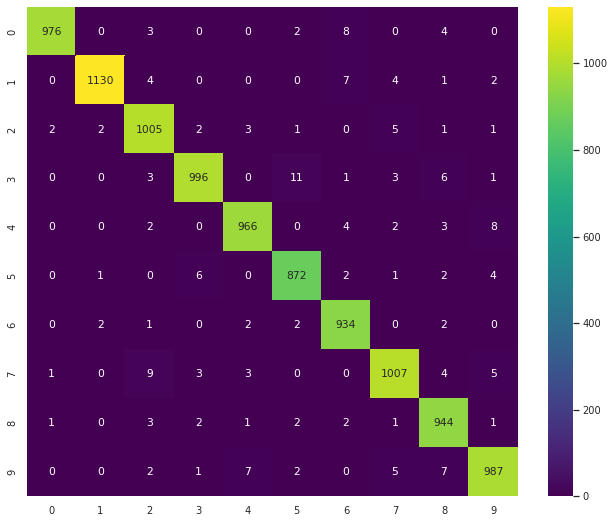

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4,suppress=True)

# Faz as predições para o conjunto de teste
predictions = model.predict(x_test)
#score = model.evaluate(x_test, y_test_oh, verbose=1) # Poderia ser usado se o objetivo é ter apenas a métrica.

# Matriz de confusão
cm = confusion_matrix(np.argmax(predictions, axis=1), y_test)
print("Matriz de confusão")
plt.figure(figsize = (11,9))
sns.set(font_scale=0.9)
sns.heatmap(cm, annot=True, fmt='g', cmap='viridis')




Acurácia balanceada: 0.9817681707260928


Matriz de confusão balanceada


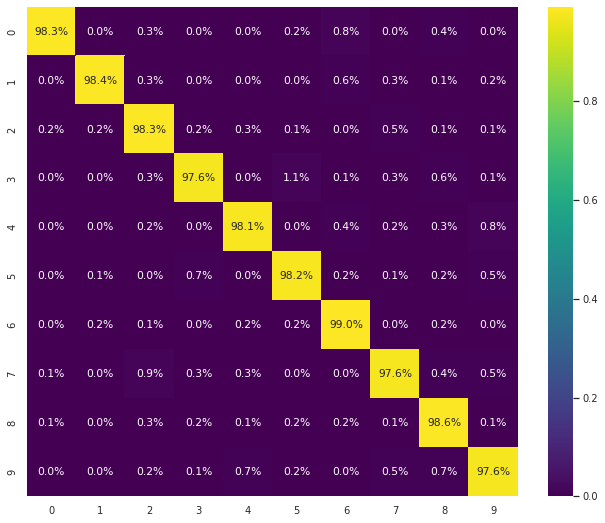

In [8]:
# Matriz de confusão normalizada
cmn = cm / cm.astype(np.float).sum(axis=1, keepdims=True)
balanced_acc = np.trace(cmn) / num_classes
print("\n\nAcurácia balanceada:", balanced_acc)

print("\n\nMatriz de confusão balanceada")
plt.figure(figsize = (11,9))
sns.set(font_scale=0.9)
sns.heatmap(cmn, annot=True, fmt='.1%', cmap='viridis')


## Cuidado!
- Número de épocas muito baixo. Nunca fazemos o treinamento de uma rede usando apenas 1 época.
- Múltiplas avaliações do conjunto de teste. Lembre-se, as avaliações são feitas no conjunto de validação. O teste deve ser usado uma ÚNICA vez. 
- Número de camadas != Número de filtros
